In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
daily_report_df = pd.read_csv('Dataset/daily_report.csv')
trades_df = pd.read_csv('Dataset/trades.csv')
logins_df = pd.read_csv('Dataset/login.csv')

In [7]:
trades_df.tail()

,ticket,login,symbol,cmd,volume,open_time,open_price,close_time,close_price,tp,sl,reason,commission,swaps,profit,volume_usd
4521772,68795989,810950,XAUUSD,0,0.10,1707738783,2020.74000,1707810805,2021.51000,2026.0,0.00000,5,0.0,0.00,7.70,40422.50
4521773,68796026,810950,XAUUSD,0,0.10,1707738794,2020.70000,1707810809,2021.50000,2026.0,0.00000,5,0.0,0.00,8.00,40422.00
4521774,68854039,810799,EURUSD,1,0.10,1707825414,1.07654,1707825616,1.07693,0.0,1.07694,5,-0.6,0.00,-3.62,21534.70
4521775,68785760,810710,GER30,1,0.03,1707728945,16994.30000,1707824463,16934.00000,0.0,17120.00000,5,0.0,0.13,18.09,10931.50
4521776,68816189,810710,DJ30,1,0.03,1707763278,38907.45000,1707816528,38821.60000,0.0,39100.00000,5,0.0,0.24,23.91,23318.71


In [8]:
daily_report_df

,login,record_time,net_deposit,balance,equity,credit,profit_closed,profit_floating,margin
0,457547,2023-01-01,0.0,0.00,0.00,0.0,0.00,0.00,0.00
1,474589,2023-01-01,0.0,0.56,0.56,0.0,0.00,0.00,0.00
2,504321,2023-01-01,0.0,2.03,2.03,0.0,0.00,0.00,0.00
3,504322,2023-01-01,0.0,0.51,0.51,0.0,0.00,0.00,0.00
4,504326,2023-01-01,0.0,0.01,0.01,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
8664156,1000055123,2024-02-29,0.0,37521.00,36507.56,0.0,-122.18,-1013.44,818.92
8664157,1000055441,2024-02-29,0.0,0.00,0.00,0.0,0.00,0.00,0.00
8664158,1000055515,2024-02-29,0.0,0.00,0.00,0.0,0.00,0.00,0.00
8664159,1000059485,2024-02-29,0.0,0.00,0.00,0.0,0.00,0.00,0.00


In [9]:
# Convert 'reg_date' and trade dates to datetime
logins_df['reg_date'] = pd.to_datetime(logins_df['reg_date'], unit='s')  # Assuming reg_date is in seconds
trades_df['open_time'] = pd.to_datetime(trades_df['open_time'], unit='s')  # Adjust if necessary
trades_df['close_time'] = pd.to_datetime(trades_df['close_time'], unit='s')  # Adjust if necessary

In [10]:
# Filter out logins that don't appear in trades
login_df = logins_df[logins_df['login'].isin(trades_df['login'])]

# Ensure the first data point starts in 2021
login_df = login_df[login_df['reg_date'].dt.year >= 2021]

# Merge the dataframes on 'login' to associate each trade with its registration date
merged_df = pd.merge(trades_df, login_df, on='login')

# Find the last trade date for each account
last_trade_date = merged_df.groupby('login')['close_time'].max().reset_index()
last_trade_date.columns = ['login', 'last_trade_date']

# Merge last_trade_date back to the login dataframe
login_df = pd.merge(login_df, last_trade_date, on='login', how='left')

# Define 'active' and 'inactive' status based on the trading in the most recent month
most_recent_trade = merged_df['close_time'].max()
one_month_ago = most_recent_trade - pd.DateOffset(months=1)
login_df['status'] = ['inactive' if x <= one_month_ago else 'active' for x in login_df['last_trade_date']]

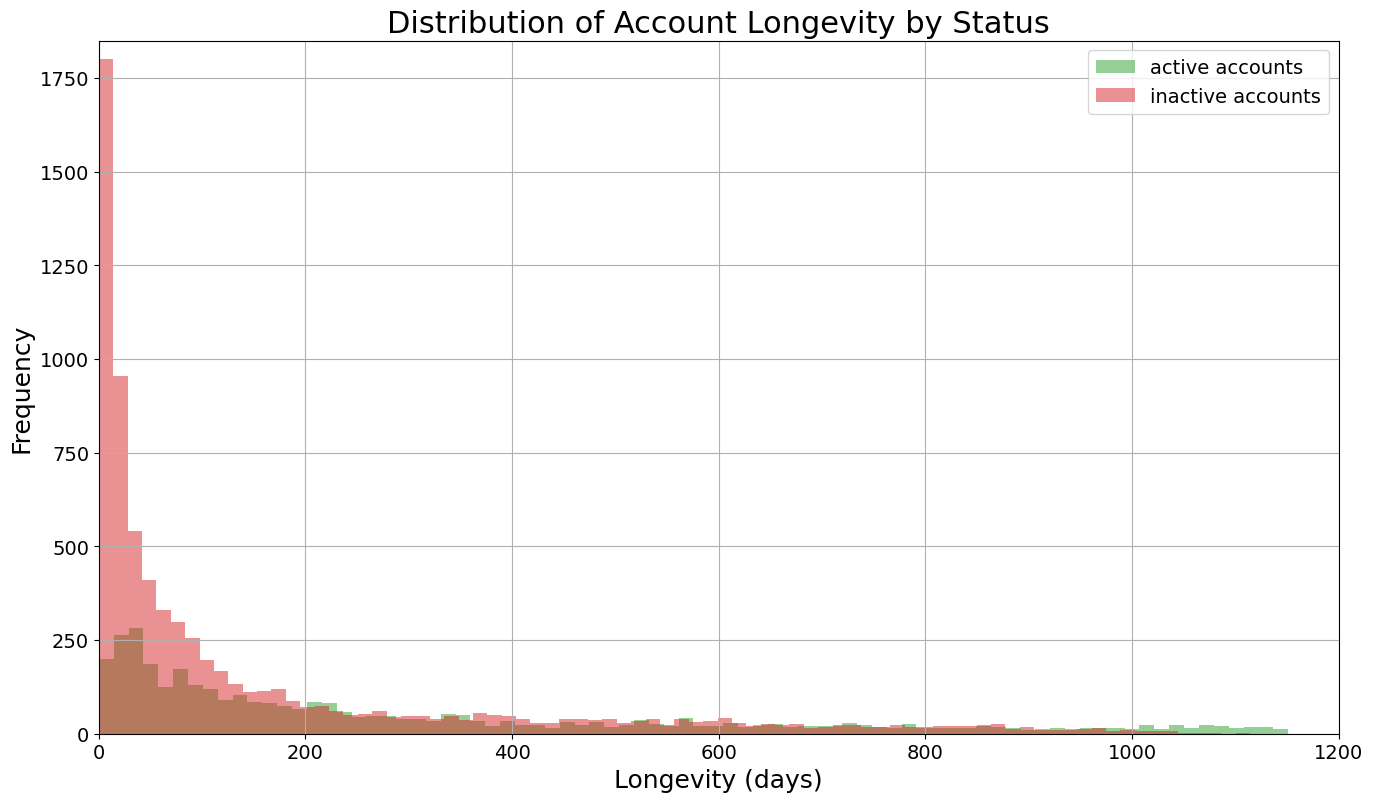

In [57]:
# Calculate longevity as the number of days from registration to last trade (or current date if active)
login_df['longevity'] = (login_df['last_trade_date'] - login_df['reg_date']).dt.days

# Now, create the histogram
plt.figure(figsize=(16, 9))
colors = {'active': 'tab:green', 'inactive': 'tab:red'}  # Define custom colors
for status, group in login_df.groupby('status'):
    plt.hist(group['longevity'], bins=80, alpha=0.5, label=f'{status} accounts', color=colors[status])

plt.title('Distribution of Account Longevity by Status', fontsize=22)
plt.xlabel('Longevity (days)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xlim([0, 1200])
plt.ylim([0, 1850])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

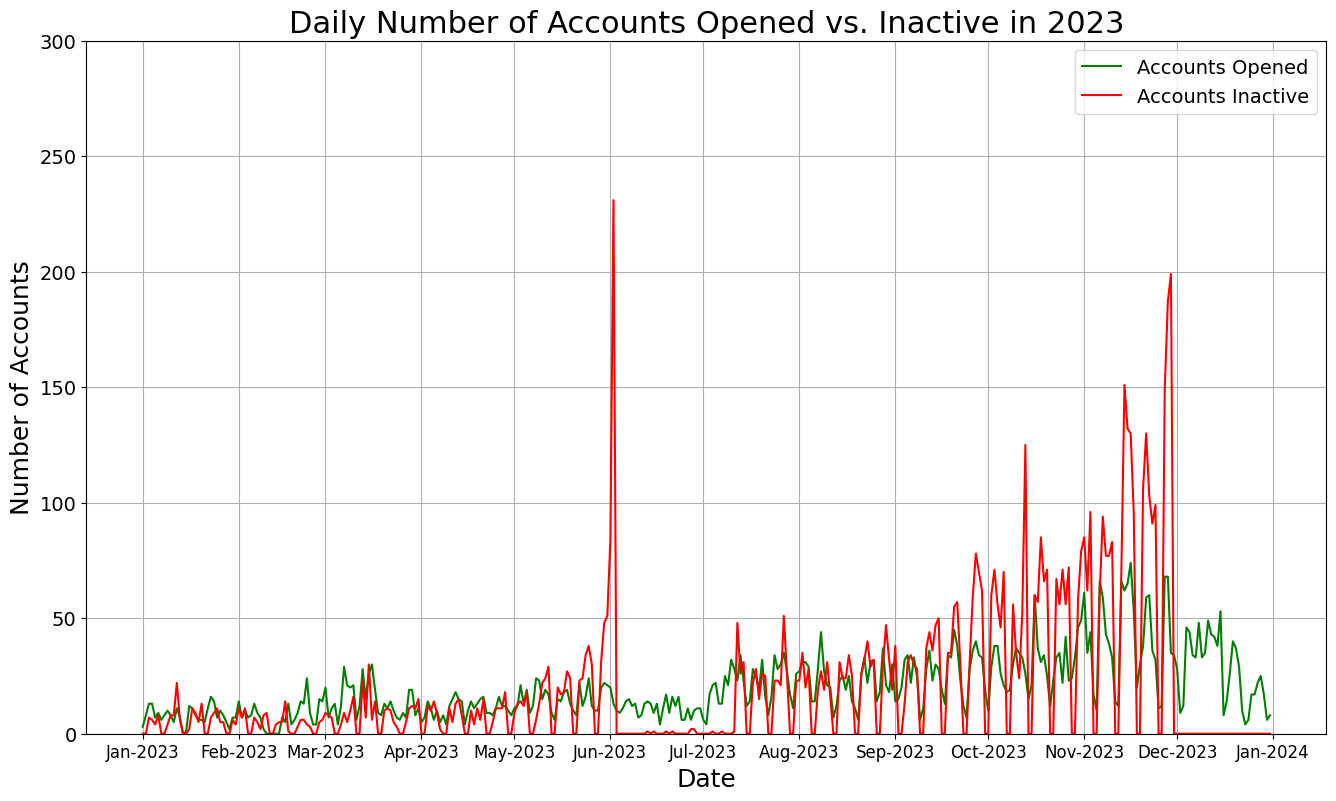

In [63]:
# Determine the start and end date for 2023 analysis
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2023-12-31')

# Adjusted date range for 2023
adjusted_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Initialize a DataFrame to store the daily counts
adjusted_daily_counts = pd.DataFrame(index=adjusted_date_range, columns=['opened', 'inactive'])
adjusted_daily_counts['opened'] = 0
adjusted_daily_counts['inactive'] = 0

# Count daily account openings from the login_df for 2023
daily_openings = login_df[login_df['reg_date'].dt.year == 2023]['reg_date'].dt.date.value_counts().sort_index()
adjusted_daily_counts['opened'] = daily_openings.reindex(adjusted_daily_counts.index.date, fill_value=0)

# Determine the last trade date for each account in trades_df for 2023
last_trade_dates = trades_df[trades_df['close_time'].dt.year == 2023].groupby('login')['close_time'].max()

# Mark accounts as inactive based on the last trade date being before the last month of 2023
one_month_ago = end_date - pd.DateOffset(months=1)
inactive_counts = last_trade_dates[last_trade_dates <= one_month_ago].groupby(last_trade_dates.dt.date).count()
adjusted_daily_counts['inactive'] = adjusted_daily_counts.index.map(inactive_counts).fillna(0)

# Plotting the line chart
plt.figure(figsize=(16, 9))
plt.plot(adjusted_daily_counts.index, adjusted_daily_counts['opened'], label='Accounts Opened', color='green')
plt.plot(adjusted_daily_counts.index, adjusted_daily_counts['inactive'], label='Accounts Inactive', color='red')

plt.title('Daily Number of Accounts Opened vs. Inactive in 2023', fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of Accounts', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.ylim([0, 300])

from matplotlib.dates import MonthLocator, DateFormatter
# Set xticks per month and format as 'Jan-2023'
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b-%Y'))

plt.legend(fontsize=14)
plt.grid(True)
plt.show()

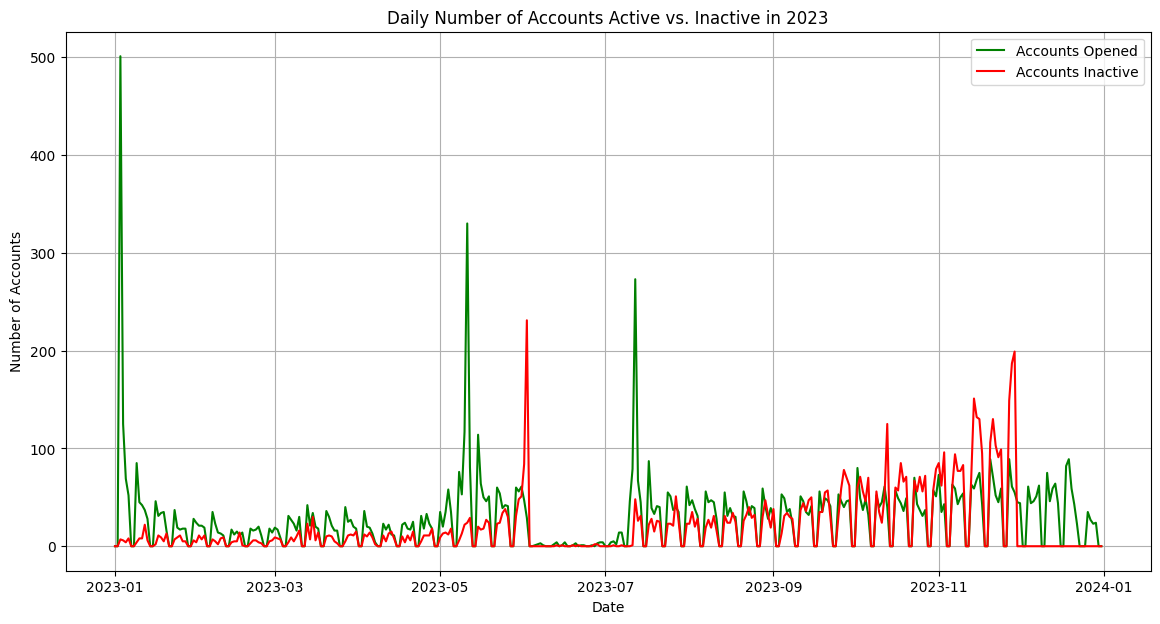

In [13]:
import matplotlib.pyplot as plt

# Determine the start and end date for 2023 analysis
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2023-12-31')

# Adjusted date range for 2023
adjusted_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Initialize a DataFrame to store the daily counts
adjusted_daily_counts = pd.DataFrame(index=adjusted_date_range, columns=['opened', 'inactive'])
adjusted_daily_counts['opened'] = 0
adjusted_daily_counts['inactive'] = 0

# Count daily first trades in trades_df for 2023
first_trades = trades_df[trades_df['open_time'].dt.year == 2023].groupby('login')['open_time'].min()
daily_first_trades = first_trades.dt.date.value_counts().sort_index()
adjusted_daily_counts['opened'] = daily_first_trades.reindex(adjusted_daily_counts.index.date, fill_value=0)

# Determine the last trade date for each account in trades_df for 2023
last_trade_dates = trades_df[trades_df['close_time'].dt.year == 2023].groupby('login')['close_time'].max()

# Mark accounts as inactive based on the last trade date being before the last month of 2023
one_month_ago = end_date - pd.DateOffset(months=1)
inactive_counts = last_trade_dates[last_trade_dates <= one_month_ago].groupby(last_trade_dates.dt.date).count()
adjusted_daily_counts['inactive'] = adjusted_daily_counts.index.map(inactive_counts).fillna(0)

# Plotting the line chart
plt.figure(figsize=(14, 7))
plt.plot(adjusted_daily_counts.index, adjusted_daily_counts['opened'], label='Accounts Opened', color='green')
plt.plot(adjusted_daily_counts.index, adjusted_daily_counts['inactive'], label='Accounts Inactive', color='red')

plt.title('Daily Number of Accounts Active vs. Inactive in 2023')
plt.xlabel('Date')
plt.ylabel('Number of Accounts')
plt.legend()
plt.grid(True)
plt.show()

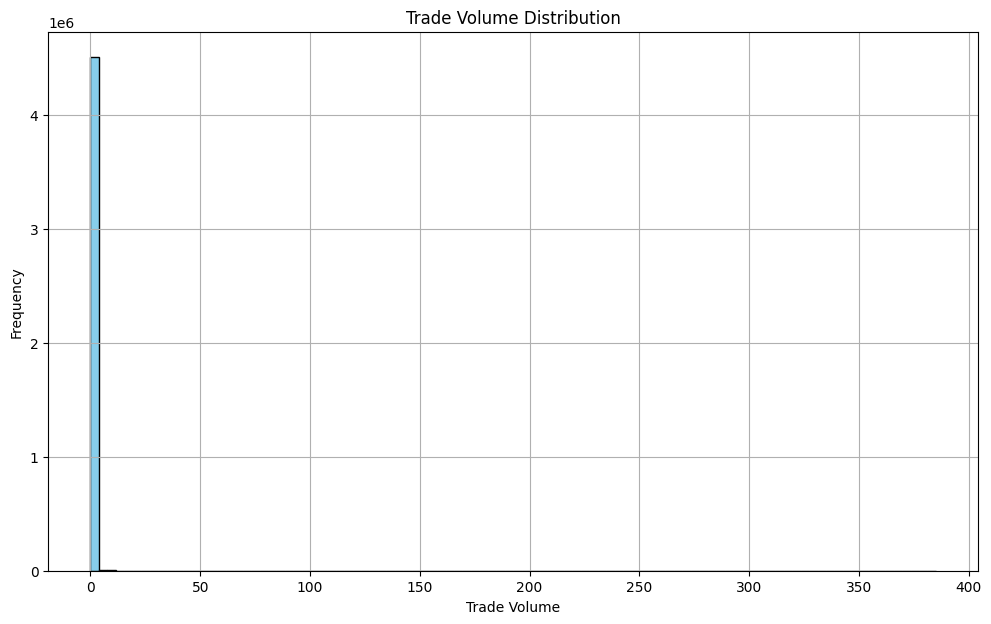

In [14]:
plt.figure(figsize=(12, 7))
plt.hist(trades_df['volume'], bins=100, color='skyblue', edgecolor='black')
plt.title('Trade Volume Distribution')
plt.xlabel('Trade Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

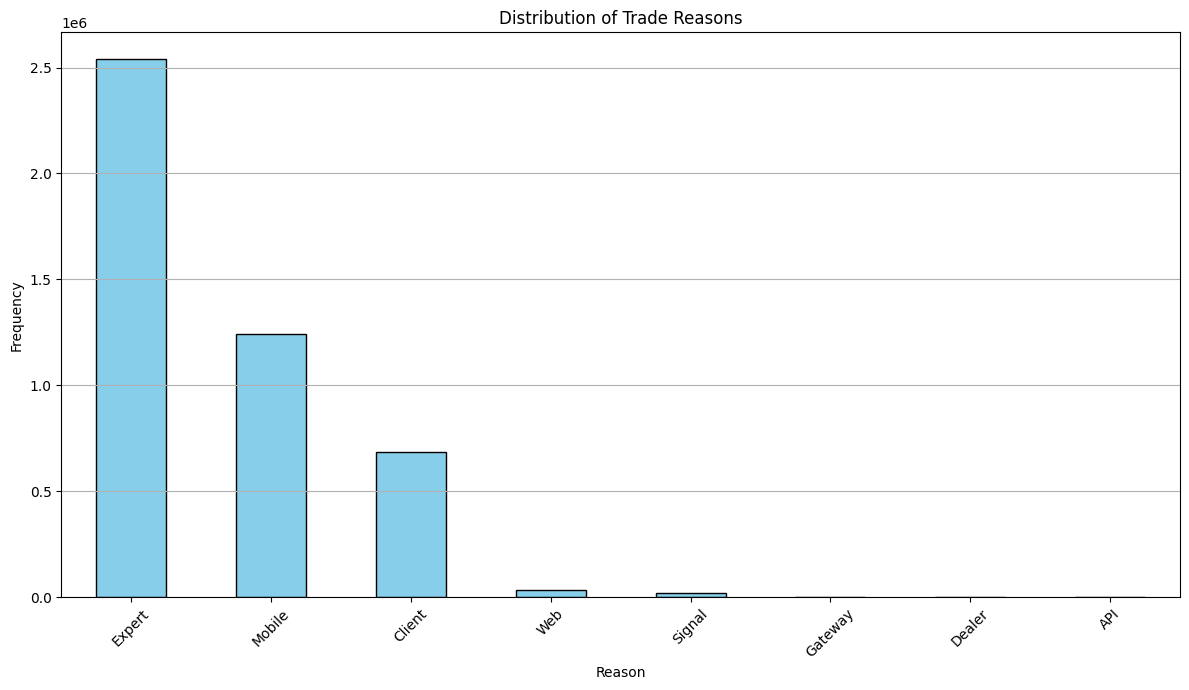

In [15]:
import matplotlib.pyplot as plt

# Create a mapping dictionary from the provided reason codes to reason descriptions
reason_mapping = {0: 'Client', 1: 'Expert', 2: 'Dealer', 3: 'Signal', 4: 'Gateway', 5: 'Mobile', 6: 'Web', 7: 'API'}

# Count the occurrences of each reason in trades_df
reason_counts = trades_df['reason'].map(reason_mapping).value_counts()

plt.figure(figsize=(12, 7))
reason_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Trade Reasons')
plt.xlabel('Reason')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

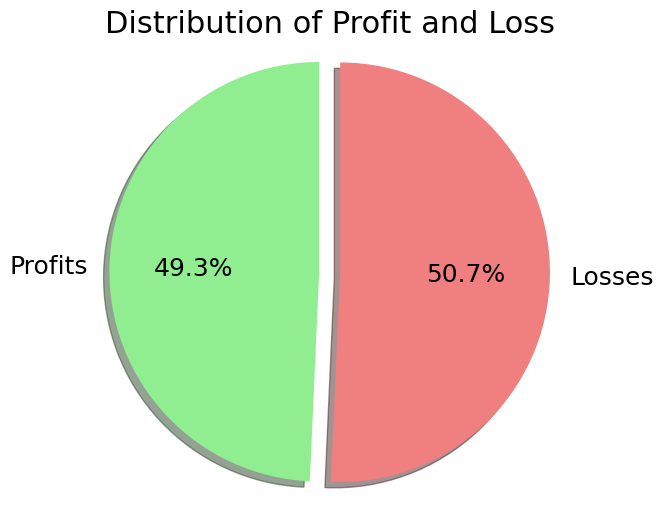

In [31]:
# Calculate the sum of positive profits (profits) and negative profits (losses)
positive_profits = trades_df['profit'][trades_df['profit'] > 0].sum()
negative_losses = trades_df['profit'][trades_df['profit'] < 0].sum()

# Prepare data for the pie chart
labels = ['Profits', 'Losses']
sizes = [positive_profits, abs(negative_losses)]  # Take the absolute value of negative losses for visualization
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # Explode the 'Positive Profits' slice

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 18})
plt.title('Distribution of Profit and Loss', fontsize=22)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

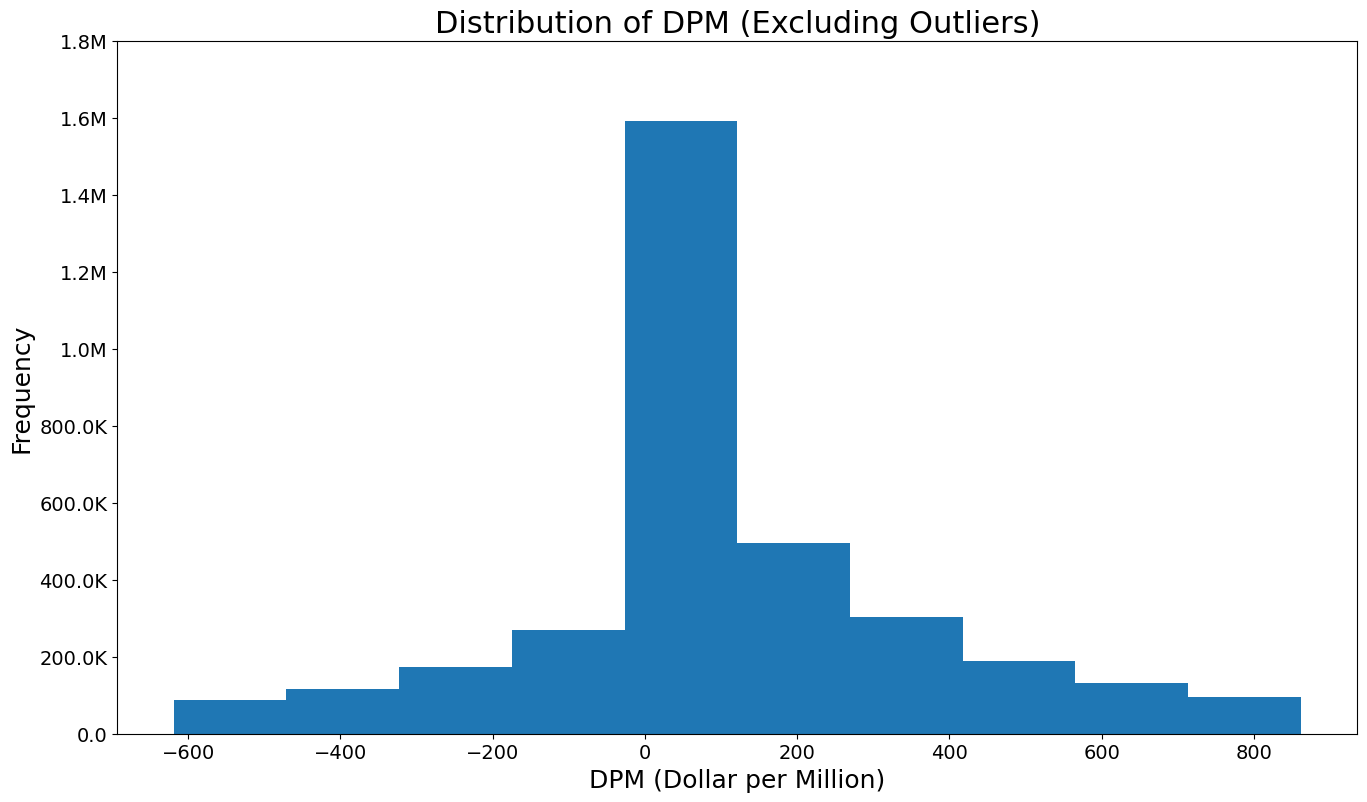

In [45]:
from matplotlib.ticker import FuncFormatter

## Calculate DPM for each trade
trades_df['dpm'] = trades_df['profit'] / (trades_df['volume_usd'] / 1_000_000)

# Determine the interquartile range (IQR)
Q1 = trades_df['dpm'].quantile(0.25)
Q3 = trades_df['dpm'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for the outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_trades_df = trades_df[(trades_df['dpm'] >= lower_bound) & (trades_df['dpm'] <= upper_bound)]

# Plotting the distribution of DPM without outliers
plt.figure(figsize=(16, 9))

# Function to format x-axis labels
def format_func(value, tick_number):
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    elif value >= 1_000:
        return f'{value / 1_000:.1f}K'
    else:
        return f'{value}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.hist(filtered_trades_df['dpm'], bins=10, color='tab:blue')
plt.title('Distribution of DPM (Excluding Outliers)', fontsize=22)
plt.xlabel('DPM (Dollar per Million)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0, 1800000])
plt.show()

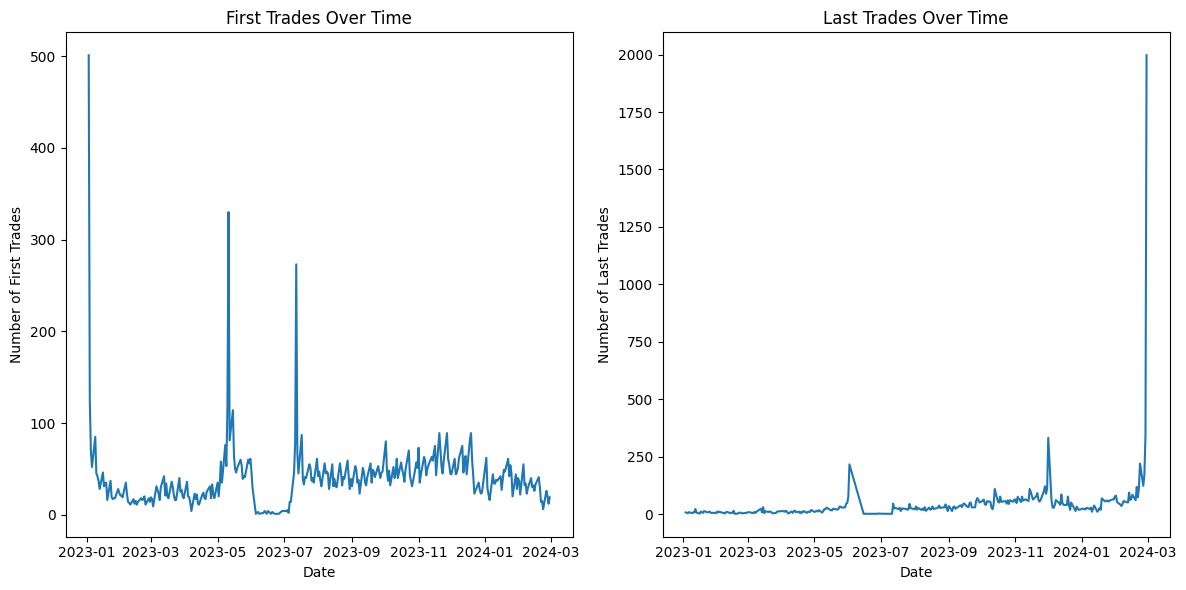

In [ ]:
# Convert the open and close times to datetime
trades_df['open_time'] = pd.to_datetime(trades_df['open_time'], unit='s')
trades_df['close_time'] = pd.to_datetime(trades_df['close_time'], unit='s')

# Group by 'login' and find the first and last trade times for each account
first_trades = trades_df.groupby('login')['open_time'].min()
last_trades = trades_df.groupby('login')['close_time'].max()

# Count the number of first and last trades by date
first_trades_count = first_trades.groupby(first_trades.dt.date).size()
last_trades_count = last_trades.groupby(last_trades.dt.date).size()

# Plotting
plt.figure(figsize=(12, 6))

# First trades
plt.subplot(1, 2, 1)
first_trades_count.plot(title='First Trades Over Time')
plt.xlabel('Date')
plt.ylabel('Number of First Trades')

# Last trades
plt.subplot(1, 2, 2)
last_trades_count.plot(title='Last Trades Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Last Trades')

plt.tight_layout()
plt.show()